In [22]:
import numpy as np
import matplotlib.pyplot as plt #matplob lib
%matplotlib inline
import os

import astropy.io.ascii as at
#from scipy.interpolate import griddata, LinearNDInterpolator, interp2d
import numpyro
import numpyro.distributions as dist
import jax
from jax import random
import jax.numpy as jnp
from jax import jit


In [4]:
# read in our MIST isochrone
iso = at.read("MIST_iso_67e56fd8ac521.iso.cmd")

# filter out AGB/RGB stars so we're left with just main sequence stars
ms = (iso['EEP'] < 605) & (iso['log_g'] > 2.0)
iso = iso[ms]

# sanity print mins and maxs of logg and teff
(min(iso['log_g']), max(iso['log_g']),
10**min(iso['log_Teff']), 10**max(iso['log_Teff']))

(np.float64(2.016473965578847),
 np.float64(5.219173330672141),
 np.float64(2852.90475694454),
 np.float64(6611.359927800581))

In [45]:
# JAXify the important MIST isochrone data
isoTeff = jnp.array(10**iso['log_Teff'])
isologg = jnp.array(iso['log_g'])
isoinitmass = jnp.array(iso['initial_mass'])

@jit
def find_closest_mass(sample_temp, sample_logg):
    # calculate distance to MIST isochrone points in (temp, logg) space
    distances = jnp.sqrt((isoTeff - sample_temp)**2
                         + (isologg - sample_logg)**2)
    
    # find indices of 2 closest points
    idx_closest = jnp.argsort(distances)[:2]
    
    # extract the two closest temps and init masses
    teff1, teff2 = isoTeff[idx_closest[0]], isoTeff[idx_closest[1]]
    # logg1, logg2 = isologg[idx_closest[0]], isologg[idx_closest[1]]
    mass1, mass2 = isoinitmass[idx_closest[0]], isoinitmass[idx_closest[1]]
    
    # interpolate in temp to grab primary mass
    interpolated_mass = jnp.interp(x=sample_temp,
                                   xp=jnp.array([teff1, teff2]),
                                   fp=jnp.array([mass1, mass2])
                                   )
    
    return interpolated_mass

# quick example
# sample_temp = 3000.0  # Replace with your random value
# sample_logg = 3.0     # Replace with your random value
# mass = find_closest_mass(sample_temp, sample_logg)
# print(mass)

In [ ]:
##### Create sample using distributions #####

# define priors for Teff_a, log(g), and mass_ratio
teffa_prior = dist.Uniform(min(isoTeff), max(isoTeff))
logga_prior = dist.Uniform(min(isologg), max(isologg))
q_prior = dist.Uniform(low=1E-6, high=1.0)

# sample the priors
sample_i = {}

sample_i['Teff_a'] = teffa_prior.sample(random.PRNGKey(0))
sample_i['log(g)_a'] = logga_prior.sample(random.PRNGKey(0))
sample_i['q'] = q_prior.sample(random.PRNGKey(0))

sample_i

{'Teff_a': Array(6414.6685, dtype=float32),
 'log(g)_a': Array(5.0515666, dtype=float32),
 'q': Array(0.94766706, dtype=float32)}

In [39]:
##### Manually assign priors #####
sample_i = {}

sample_i['Teff_a'] = 3000.0
sample_i['log(g)_a'] = 3.0
sample_i['q'] = 0.8

In [ ]:
##### Grab primary mass #####
sample_i['M_a'] = find_closest_mass(sample_i['Teff_a'], sample_i['log(g)_a'])
sample_i['M_a']

Array(0.14551444, dtype=float32)

In [47]:
@jit
def find_closest_teff_logg(mass_a, q):
    # calculate secondary mass
    mass_b = mass_a * q

    # find closest masses on MIST isochrone to mass_b
    distances = jnp.abs(isoinitmass - mass_b)
    
    # find indices of 2 closest points
    idx_closest = jnp.argsort(distances)[:2]
    
    # extract the two closest temps and log(g)s
    teff1, teff2 = isoTeff[idx_closest[0]], isoTeff[idx_closest[1]]
    logg1, logg2 = isologg[idx_closest[0]], isologg[idx_closest[1]]
    mass1, mass2 = isoinitmass[idx_closest[0]], isoinitmass[idx_closest[1]]
    
    # interpolate in temp to grab primary mass
    interpolated_teff = jnp.interp(x=mass_a,
                                   xp=jnp.array([mass1, mass2]),
                                   fp=jnp.array([teff1, teff2])
                                   )
    
    interpolated_logg = jnp.interp(x=mass_a,
                                   xp=jnp.array([mass1, mass2]),
                                   fp=jnp.array([logg1, logg2])
                                   )
    
    return mass_b, interpolated_teff, interpolated_logg

# quick example
mass_a = 1.0
q = 0.8
mass_b, teff, logg = find_closest_teff_logg(mass_a, q)
print(teff, logg)

4827.7217 4.6057315


In [49]:
##### Grab secondary mass, Teff, log(g) #####
sample_i['M_b'], sample_i['Teff_b'], sample_i['log(g)_b'] = find_closest_teff_logg(sample_i['M_a'], sample_i['q'])
sample_i['M_b'], sample_i['Teff_b'], sample_i['log(g)_b']

(Array(0.11641156, dtype=float32),
 Array(2852.9048, dtype=float32),
 Array(5.2191734, dtype=float32))

In [50]:
sample_i

{'Teff_a': 3000.0,
 'log(g)_a': 3.0,
 'q': 0.8,
 'M_a': Array(0.14551444, dtype=float32),
 'M_b': Array(0.11641156, dtype=float32),
 'Teff_b': Array(2852.9048, dtype=float32),
 'log(g)_b': Array(5.2191734, dtype=float32)}

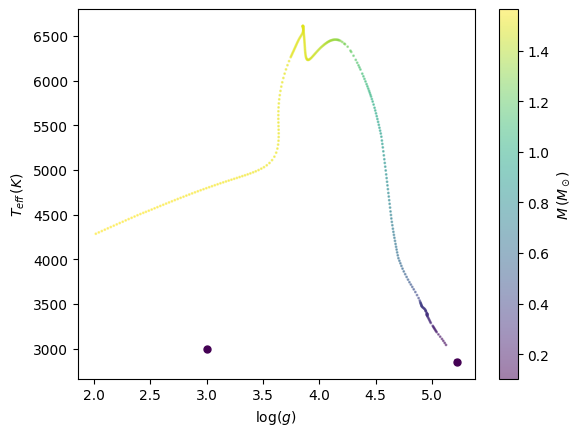

In [ ]:
##### Plotting #####
fig, ax = plt.subplots()

ax.scatter(isologg, isoTeff, c=isoinitmass, s=1, alpha=0.5)
ax.scatter(sample_i['log(g)_a'], sample_i['Teff_a'], c=sample_i['M_a'], s=25, label='Primary')
ax.scatter(sample_i['log(g)_b'], sample_i['Teff_b'], c=sample_i['M_b'], s=25, label='Secondary')

ax.set_xlabel(r'$\log(g)$')
ax.set_ylabel(r'$T_{eff} \, (K)$')

fig.colorbar(ax.collections[0], label=r'$M \, ({M_\odot})$')